In [1]:
import numpy as np
import pandas as pd

import os
print(os.listdir("/Users/chidex/Nonsegmented"))

['Cleavers', 'Sugar beet', 'Common Chickweed', 'Loose Silky-bent', 'Scentless Mayweed', 'Shepherd’s Purse', 'Fat Hen', 'Common wheat', 'Black-grass', 'Small-flowered Cranesbill', 'Charlock', 'Maize']


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import math 
import cv2 
from glob import glob 
import itertools


from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,CSVLogger

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [4]:
scale = 70
seed = 7

In [5]:
path_to_images = '/Users/chidex/Nonsegmented/*/*.png'
images = glob(path_to_images)
trainingset = []
traininglabels = []
num = len(images)
count = 1
#READING IMAGES AND RESIZING THEM
for i in images:
    print(str(count)+'/'+str(num),end='\r')
    trainingset.append(cv2.resize(cv2.imread(i),(scale,scale)))
    traininglabels.append(i.split('/')[-2])
    count=count+1
trainingset = np.asarray(trainingset)
traininglabels = pd.DataFrame(traininglabels)

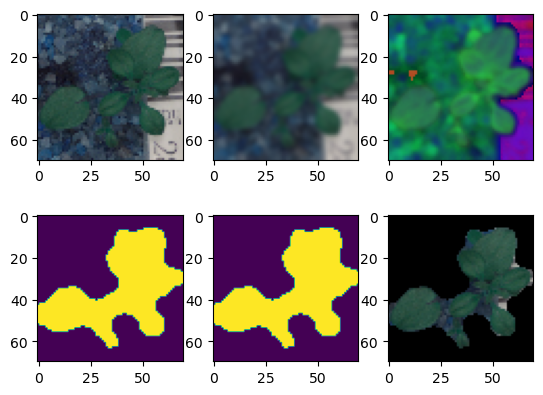

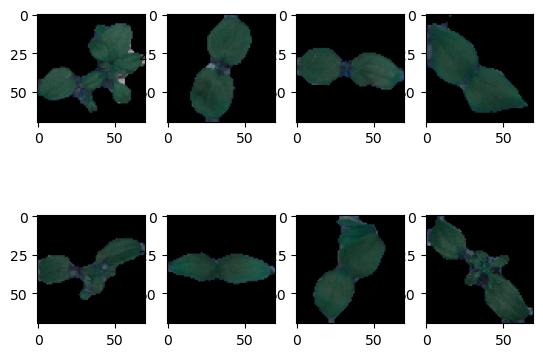

In [6]:
new_train = []
sets = []
getEx = True
for i in trainingset:
    blurr = cv2.GaussianBlur(i,(5,5),0)
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)
    #GREEN PARAMETERS
    lower = (25,40,50)
    upper = (75,255,255)
    mask = cv2.inRange(hsv,lower,upper)
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
    boolean = mask>0
    new = np.zeros_like(i,np.uint8)
    new[boolean] = i[boolean]
    new_train.append(new)
    
    if getEx:
        plt.subplot(2,3,1);plt.imshow(i) # ORIGINAL
        plt.subplot(2,3,2);plt.imshow(blurr) # BLURRED
        plt.subplot(2,3,3);plt.imshow(hsv) # HSV CONVERTED
        plt.subplot(2,3,4);plt.imshow(mask) # MASKED
        plt.subplot(2,3,5);plt.imshow(boolean) # BOOLEAN MASKED
        plt.subplot(2,3,6);plt.imshow(new) # NEW PROCESSED IMAGE
        plt.show()
        getEx = False
new_train = np.asarray(new_train)

# CLEANED IMAGES
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(new_train[i])

Classes['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherd’s Purse' 'Small-flowered Cranesbill' 'Sugar beet']
12


<AxesSubplot:ylabel='0'>

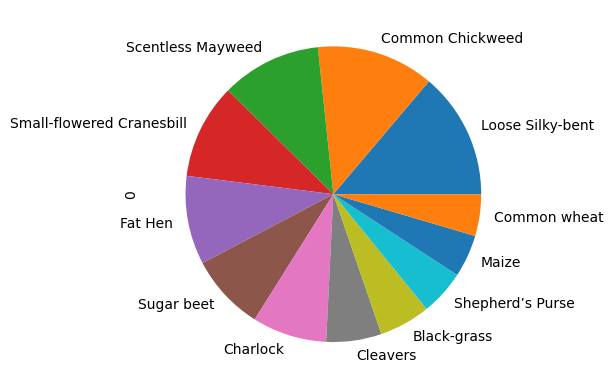

In [7]:
labels = preprocessing.LabelEncoder()
labels.fit(traininglabels[0])
print('Classes'+str(labels.classes_))
encodedlabels = labels.transform(traininglabels[0])
clearalllabels = np_utils.to_categorical(encodedlabels)
classes = clearalllabels.shape[1]
print(str(classes))
traininglabels[0].value_counts().plot(kind='pie')

In [8]:
new_train = new_train/255
x_train,x_test,y_train,y_test = train_test_split(new_train,clearalllabels,test_size=0.1,random_state=seed,stratify=clearalllabels)

In [9]:
generator = ImageDataGenerator(rotation_range = 180,zoom_range = 0.1,width_shift_range = 0.1,height_shift_range = 0.1,horizontal_flip = True,vertical_flip = True)
generator.fit(x_train)

In [10]:
np.random.seed(seed)

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(scale, scale, 3), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Metal device set to: Apple M1


2022-12-16 01:10:12.174138: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-16 01:10:12.175732: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 66, 66, 64)        4864      
                                                                 
 batch_normalization (BatchN  (None, 66, 66, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        102464    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 64)       0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 31, 31, 64)       256       
 hNormalization)                                                 
                                                        

(4989, 70, 70, 3) (4989, 12)
(555, 70, 70, 3) (555, 12)


2022-12-16 01:10:48.820391: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/50


2022-12-16 01:10:49.942575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


156/156 [==============================] - 32s 161ms/step - loss: 2.1186 - accuracy: 0.3536
Epoch 2/50
156/156 [==============================] - 24s 151ms/step - loss: 1.4264 - accuracy: 0.5139
Epoch 3/50
156/156 [==============================] - 23s 150ms/step - loss: 1.1691 - accuracy: 0.5993
Epoch 4/50
156/156 [==============================] - 24s 155ms/step - loss: 0.9743 - accuracy: 0.6801
Epoch 5/50
156/156 [==============================] - 25s 157ms/step - loss: 0.8311 - accuracy: 0.7244
Epoch 6/50
156/156 [==============================] - 25s 163ms/step - loss: 0.7309 - accuracy: 0.7535
Epoch 7/50
156/156 [==============================] - 24s 157ms/step - loss: 0.6517 - accuracy: 0.7843
Epoch 8/50
156/156 [==============================] - 25s 157ms/step - loss: 0.6084 - accuracy: 0.7939
Epoch 9/50
156/156 [==============================] - 24s 156ms/step - loss: 0.5216 - accuracy: 0.8190
Epoch 10/50
156/156 [==============================] - 25s 159ms/step - loss: 0.5198

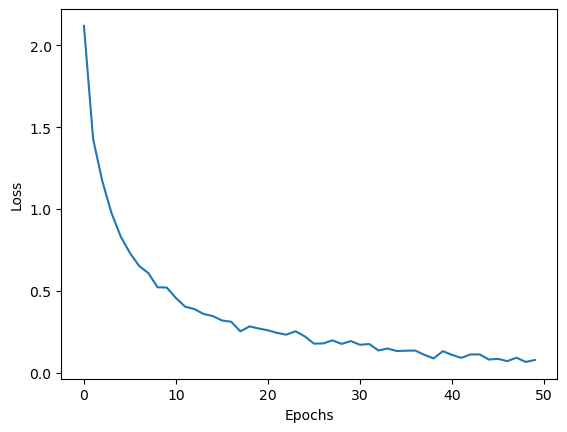

In [11]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
history = model.fit(x_train, y_train, epochs=50)

plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [12]:
pred_labels = model.predict(x_test)
print(pred_labels.shape)
acc = model.evaluate(x_test, y_test)
print("Testing accuracy : {}".format(acc[-1] * 100))

2022-12-16 01:31:43.619283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 2s 68ms/step
(555, 12)
 1/18 [>.............................] - ETA: 4s - loss: 0.7258 - accuracy: 0.7812

2022-12-16 01:31:45.259032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 46ms/step - loss: 0.5299 - accuracy: 0.8559
Testing accuracy : 85.58558821678162


In [15]:
import tensorflow as tf
# Save tf.keras model in HDF5 format.
keras_file = "keras_model.h5"
model.save(keras_file)

In [16]:
tflite_model = tf.keras.models.load_model("keras_model.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(tflite_model)
tflite_save = converter.convert()
open("generated.tflite", "wb").write(tflite_save)

INFO:tensorflow:Assets written to: /var/folders/s6/lg5hwyy57txgyc_7f19_6vx00000gn/T/tmpd6igajw2/assets


INFO:tensorflow:Assets written to: /var/folders/s6/lg5hwyy57txgyc_7f19_6vx00000gn/T/tmpd6igajw2/assets
2022-12-16 01:40:07.472955: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-16 01:40:07.472980: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-12-16 01:40:07.473105: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/s6/lg5hwyy57txgyc_7f19_6vx00000gn/T/tmpd6igajw2
2022-12-16 01:40:07.476530: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2022-12-16 01:40:07.476537: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /var/folders/s6/lg5hwyy57txgyc_7f19_6vx00000gn/T/tmpd6igajw2
2022-12-16 01:40:07.487722: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-12-16 01:40:07.604065: I tensorflow/cc/saved_model/loader.cc:212] Running initialization

13276172

18/18 [==============================] - 2s 74ms/step
[1.2597368e-06 1.3189415e-04 1.2092327e-06 1.4317735e-05 6.8477231e-05
 9.9649721e-01 8.1210254e-07 1.1954486e-03 2.9090045e-06 1.6421725e-05
 1.4478180e-05 2.0555886e-03]
5
Predicted label : Fat Hen


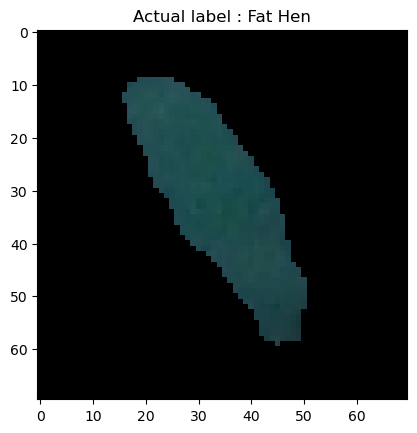

18/18 [==============================] - 1s 44ms/step
[6.3195121e-10 1.4221070e-08 2.8540791e-08 7.4456348e-09 1.9330978e-11
 2.4694763e-10 4.8647122e-09 3.7274663e-08 7.0297768e-11 9.5757302e-10
 9.9999976e-01 1.3423660e-07]
10
Predicted label : Small-flowered Cranesbill


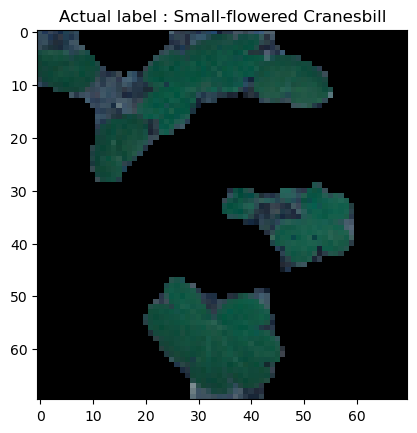

18/18 [==============================] - 1s 46ms/step
[1.3998662e-04 5.5543346e-06 2.3293048e-04 2.6054576e-04 1.9113420e-04
 9.9724603e-01 1.3399626e-03 4.7367539e-05 1.6964166e-04 1.8882324e-04
 1.2722833e-04 5.0882089e-05]
5
Predicted label : Fat Hen


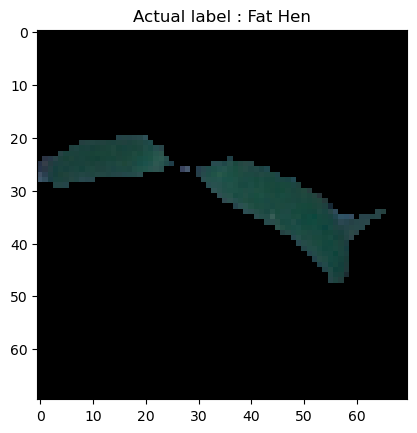

18/18 [==============================] - 1s 50ms/step
[4.3712252e-01 1.2866873e-04 1.0582846e-04 1.6795544e-02 7.6000550e-04
 9.4708242e-04 4.6664146e-01 1.9758239e-02 1.2043701e-04 6.5697049e-04
 2.6255520e-03 5.4337654e-02]
6
Predicted label : Loose Silky-bent


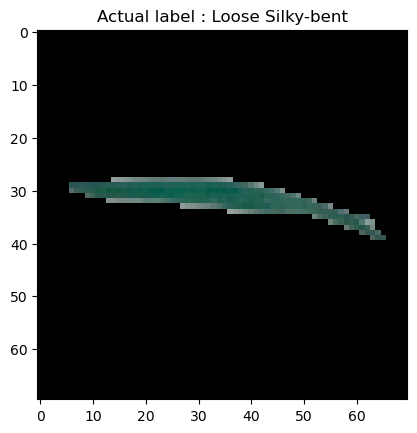

In [19]:
from tensorflow.keras.utils import save_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import load_img

#122, 11, 223, 355
idxss = [122,11,223,355]
for idx in idxss:
    pred_label = model.predict(x_test)
    print(pred_label[idx])
    print(np.argmax(pred_label[idx], axis=0))
    print("Predicted label : " + str(labels.classes_[np.argmax(pred_label[idx], axis=0)]))

    plt.imshow(x_test[idx])
    plt.title("Actual label : " + str(labels.classes_[np.argmax(y_test[idx], axis=0)]))
    plt.show()

    img = x_test[idx]
    img_array = img_to_array(img)
    # save the image with a new filename
    save_img("test" + str(idx) + ".png", img_array)